In [ ]:
!pip install more_itertools 

In [6]:
import os
import pandas as pd
import numpy  as np
import more_itertools
from scipy.fft    import dct, idct
from scipy.signal import butter, savgol_filter, ellip, filtfilt, detrend
from scipy.stats import zscore
from scipy.signal import savgol_filter
from matplotlib   import pylab as plt

## Loading data

In [7]:
# paths were the raw data is
root_path = 'data/'
data_path = os.path.join(root_path, 'Segmented')
emg_path  = os.path.join(data_path, 'EMG')

# paths were the preprocessed data should be
out_path = os.path.join(root_path, 'Processed')
emg_out_path = os.path.join(out_path, 'EMG')

# check if the output folders exist and create them if necessary
for folder in [out_path, emg_out_path]:
    if not os.path.exists(folder):
        os.mkdir(folder)

# list all files (ignoring the hidden macos file)
emg_files = [x for x in os.listdir(emg_path) if x.endswith('.csv')]

In [8]:
emg_files

['02_EMG_SS2023_Exp1_Session1_Shimmer_F16C_Calibrated_SD.csv',
 '04_EMG_SS2023_Exp1_Session1_Shimmer_EC93_Calibrated_SD.csv',
 '03_EMG_SS2023_Exp1_Session1_Shimmer_EC8E_Calibrated_SD.csv',
 '01_EMG_SS2023_Exp1_Session1_Shimmer_F0BA_Calibrated_SD.csv']

## Functions for preprocessing

In [9]:
# Reshape a numpy array 'a' of shape (n, x) to form shape((n - window_size), window_size, x))
def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size + 1, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [10]:
# all 3 functions taken from matlab implementation after Anne Grübler
def notch_filter(data, notch, width, fs):
    fa = (notch - width) / (fs/2)
    fb = (notch + width) / (fs/2)
    Wn = np.array([fa, fb])
    order = 4
    b, a = butter(order, Wn, btype='stop')
    return filtfilt(b, a, data)

def elliptic_filter(data, flow, fhigh, fs):
    Wn    = np.array([flow, fhigh]) * (2/fs)
    order = 4
    maxRipple      = 0.1
    minAttenuation = 40
    b, a  = ellip(order, maxRipple, minAttenuation, Wn, btype='stop')
    return filtfilt(b, a, data)

def local_filter(data, notch, width, flow, fhigh, fs):
    signal = data
    if (len(notch) > 1):
        for kk in range(len(notch)):
            signal = notch_filter(signal, notch[kk], width[kk], fs)
    else:
        signal = notch_filter(signal, notch, width, fs)
    signal = elliptic_filter(signal, flow, fhigh, fs)
    return detrend(signal)

## Plot before processing

Index(['Unnamed: 0', 'timestamp_UNIX', 'CH1', 'CH2', 'trial'], dtype='object')
Index(['Unnamed: 0', 'timestamp_UNIX', 'CH1', 'CH2', 'trial'], dtype='object')
Index(['Unnamed: 0', 'timestamp_UNIX', 'CH1', 'CH2', 'trial'], dtype='object')
Index(['Unnamed: 0', 'timestamp_UNIX', 'CH1', 'CH2', 'trial'], dtype='object')


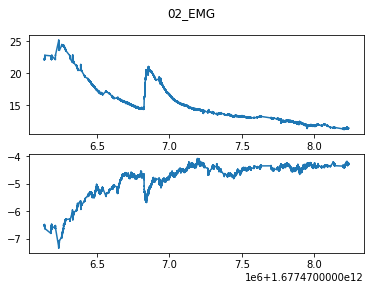

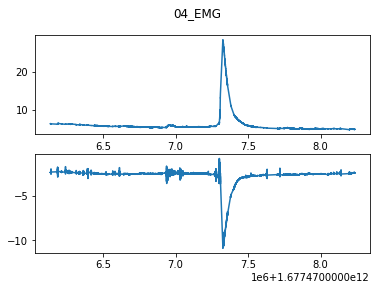

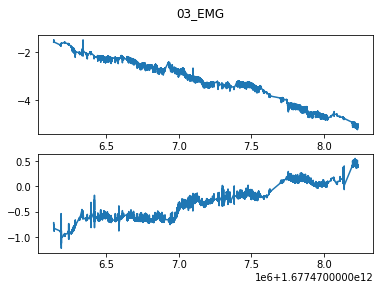

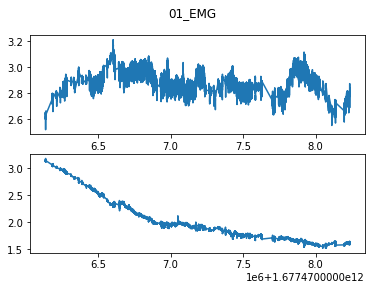

In [11]:
#Channel 1 is the corrugator (frown), channel 2 is the zygomaticus (smile)
for file in emg_files:
    filepath = os.path.join(emg_path, file)
    df       = pd.read_csv(filepath)
    
    columns = df.columns
    print(columns)
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(df.timestamp_UNIX, df.CH1)
    ax[1].plot(df.timestamp_UNIX, df.CH2)
    plt.suptitle(file[:6])

## Preprocessing

In [12]:
fs      = 512 # emg sampling frequency
f_notch = np.array([60, 120, 180, 240]) # notch frequencies to filter out because of line noise
width   = np.ones(len(f_notch)) * 3;              # width/2 of each notch
cutlow  = 5    # lower cut-off frequency for elliptic filter
cuthigh = 250  # upper cut-off frequency for elliptic filter

# Windowing
step_size = 1 #slide
window_size = 51 #window of 100ms at 512Hz = 51 samples

# Do pre-processing per file
for file in emg_files:
    filepath = os.path.join(emg_path, file)
    df       = pd.read_csv(filepath)
    
    columns = df.columns
    
    df_ch1 = df[columns[2]]
    df_ch2 = df[columns[3]]
    
    # filter and save it into the data frame loaded
    df_ch1 = local_filter(df_ch1, f_notch, width, cutlow, cuthigh, fs)
    df_ch2 = local_filter(df_ch2, f_notch, width, cutlow, cuthigh, fs)
    
    # calculate z-scores
    df_ch1 = zscore(df_ch1)
    df_ch2 = zscore(df_ch2)
    
    # calculate RMS
    ## ch1
    rms_data = []
    windowed_data = list(more_itertools.windowed(df_ch1,52,step = 1))
    leftover_size = len(df_ch1) - len(windowed_data)
    for window in windowed_data:
        rms_data.append(np.sqrt(np.square(window).mean(axis=0)))
    rms_data.extend([0]*leftover_size)
    df_ch1 = rms_data
    
    ## ch2
    rms_data = []
    windowed_data = list(more_itertools.windowed(df_ch2,52,step = 1))
    for window in windowed_data:
        rms_data.append(np.sqrt(np.square(window).mean(axis=0)))
    rms_data.extend([0]*leftover_size)
    df_ch2 = rms_data
    
    # low pass to further remove noise
    df_ch1 = savgol_filter(df_ch1, 501, 3)
    df_ch2 = savgol_filter(df_ch2, 501, 3)
    
    df = pd.DataFrame({columns[1]: df[columns[1]], columns[2]: df_ch1, columns[3]: df_ch2, columns[4]: df[columns[4]]})
    df.to_csv(os.path.join(emg_out_path, file), index=False)

In [13]:
# Example from https://qiita.com/NLPingu/items/bd939f1d2608a16e0282

list(more_itertools.windowed(df_ch1,8,step = 1))[-1]
len(list(more_itertools.windowed(df_ch1,8,step = 1)))

729370

## Plot after processing

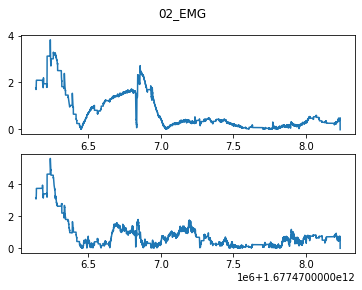

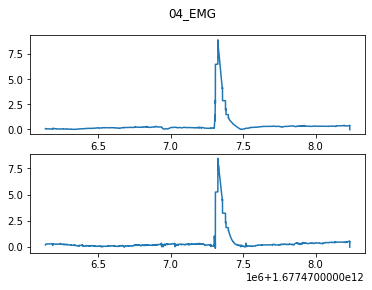

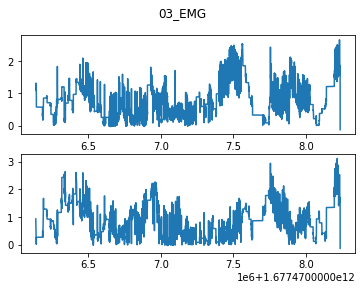

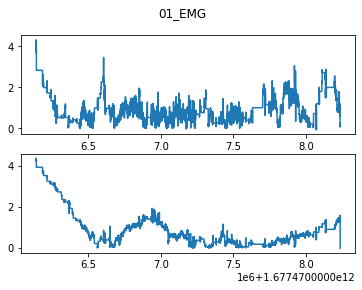

In [14]:
for file in emg_files:
    filepath = os.path.join(emg_out_path, file)
    df       = pd.read_csv(filepath)
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(df.timestamp_UNIX, df.CH1)
    ax[1].plot(df.timestamp_UNIX, df.CH2)
    plt.suptitle(file[:6])

## Plot trial

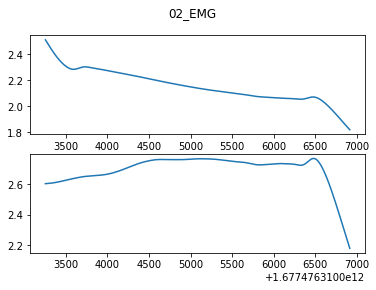

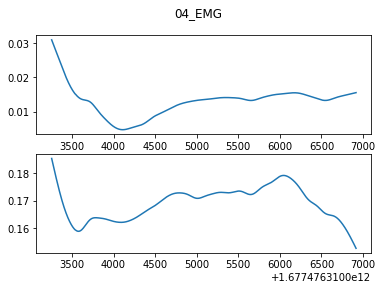

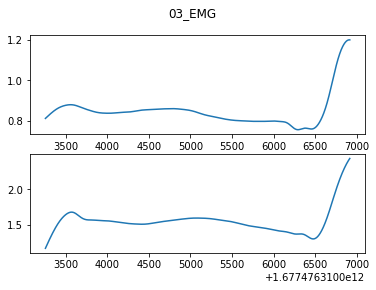

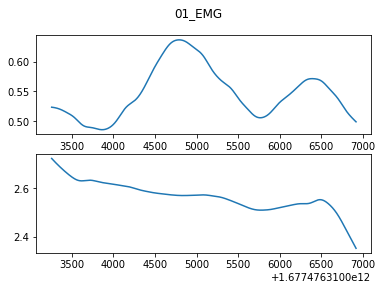

In [15]:
trial_2_plot = 6
for file in emg_files:
    filepath = os.path.join(emg_out_path, file)
    df       = pd.read_csv(filepath)
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(df.timestamp_UNIX[df.trial == trial_2_plot], df.CH1[df.trial == trial_2_plot])
    ax[1].plot(df.timestamp_UNIX[df.trial == trial_2_plot], df.CH2[df.trial == trial_2_plot])
    plt.suptitle(file[:6])